In [1]:
import os
import csv
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv3D,Conv2D, ConvLSTM2D, BatchNormalization, MaxPooling2D, Flatten, Dense
import glob as glob

from tkinter import Tcl


2023-08-23 16:33:36.009413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 16:33:36.051836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 16:33:36.052546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 16:33:36.813478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pip install Models

  Using cached models-0.9.3.tar.gz (16 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-cgej4yh6/models_9975e025ceee4a25bf84a7aaf65acb86/setup.py", line 25, in <module>
          import models
        File "/tmp/pip-install-cgej4yh6/models_9975e025ceee4a25bf84a7aaf65acb86/models/__init__.py", line 23, in <module>
          from base import *
      ModuleNotFoundError: No module named 'base'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pi

In [3]:

# Sorted order of images


data_dir = '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900'

dir1 = glob.glob("/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/" +"*.png")


X_sorted = Tcl().call('lsort', '-dict', dir1)
X_sorted[0:10]


('/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev1.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev2.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev3.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev4.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev5.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev6.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev7.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev8.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev9.00.png',
 '/home/rakesh/Documents/VarMobility/images_chai/chai_0.900/timev10.00.png')

In [4]:
# image pre=processing

def load_images_from_folder(data_dir):
   
   
   X_sorted = Tcl().call('lsort', '-dict', dir1)
    
   print(len(X_sorted))

   images = []
   for i in range(len(X_sorted)):
    
     img = tf.keras.preprocessing.image.load_img(X_sorted[i])
     #img = cv2.imread(X_sorted[i])
     img= tf.keras.preprocessing.image.smart_resize(img, [64,64])
     img = np.array(img)
    
     img = img.astype('float32')/255.0
     images.append(img)
   return images


# Load images from the folder

images = load_images_from_folder(data_dir)
images = np.array(images)

print(images.shape)

5000


2023-08-23 16:33:40.369927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 16:33:40.370969: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(5000, 64, 64, 3)


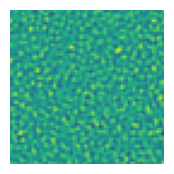

In [5]:
plt.figure(figsize=(2,2))
plt.imshow(images[100])
plt.axis('off')
plt.show()

In [6]:
num_frames = 1
image_size = (64,64)

dataset = np.empty((len(images), num_frames, image_size[0], image_size[1], 3), dtype=np.float32)

for i in range(len(images)):
   images = np.array(images)
   dataset[i] = images[i]
print(dataset.shape)
print(dataset.shape[0])

(5000, 1, 64, 64, 3)
5000


In [7]:
# Split the data into training and validation sets

indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) :]

train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

def create_shifted_frames(data):
    x = data[:-1, :, :]  # Exclude the last time step to create input frames
    y = data[1:, :, :] 
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3999, 1, 64, 64, 3)
(3999, 1, 64, 64, 3)
(999, 1, 64, 64, 3)
(999, 1, 64, 64, 3)


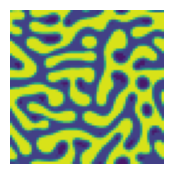

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(x_val[1][0])
plt.axis('off')
plt.show()

In [9]:
# clear history each & every steps

from keras import backend as K
K.clear_session()

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import ConvLSTM2D,TimeDistributed,Conv2D,Dropout,Flatten,MaxPooling2D,Dense

In [11]:
# Define the ConvLSTM model

inp = Input(shape=(None, 64,64,3))

x = ConvLSTM2D(filters=8,
               kernel_size =(5,5),
               padding='same',
               return_sequences=True,
               activation='relu')(inp)
x = BatchNormalization()(x)

x = ConvLSTM2D(filters = 8,
               kernel_size = (3,3),
               padding = 'same',
               return_sequences = True,
               activation = 'relu')(x)

x = BatchNormalization()(x)

x = ConvLSTM2D(filters = 8,
               kernel_size = (1,1),
               padding = 'same',
               return_sequences = True,
               activation = 'relu')(x)


x = Conv3D(filters=3, kernel_size=(3,3,3), activation='sigmoid', padding='same')(x)

model = keras.models.Model(inp,x)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 3)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 8)   8832      
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 8)  32        
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 8)   4640      
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 8)  32        
 hNormalization)                                                 
                                                             

In [12]:
# Define some callbacks to improve training.


# Define modifiable training hyperparameters.
epochs = 20
batch_size = 8

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val)

)


Epoch 1/20
500/500 [==============================] - 145s 278ms/step - loss: 0.0478 - accuracy: 0.7092 - val_loss: 0.0502 - val_accuracy: 0.6706
Epoch 2/20
500/500 [==============================] - 139s 278ms/step - loss: 0.0445 - accuracy: 0.7327 - val_loss: 0.0461 - val_accuracy: 0.7244
Epoch 3/20
500/500 [==============================] - 139s 277ms/step - loss: 0.0438 - accuracy: 0.7360 - val_loss: 0.0457 - val_accuracy: 0.7170
Epoch 4/20
500/500 [==============================] - 139s 278ms/step - loss: 0.0434 - accuracy: 0.7389 - val_loss: 0.0453 - val_accuracy: 0.7310
Epoch 5/20
500/500 [==============================] - 139s 278ms/step - loss: 0.0432 - accuracy: 0.7402 - val_loss: 0.0453 - val_accuracy: 0.7304
Epoch 6/20
500/500 [==============================] - 138s 277ms/step - loss: 0.0429 - accuracy: 0.7415 - val_loss: 0.0449 - val_accuracy: 0.7312
Epoch 7/20
500/500 [==============================] - 138s 277ms/step - loss: 0.0426 - accuracy: 0.7428 - val_loss: 0.0441 -

In [13]:
preds = model.predict(y_val)

32/32 [==============================] - 7s 187ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


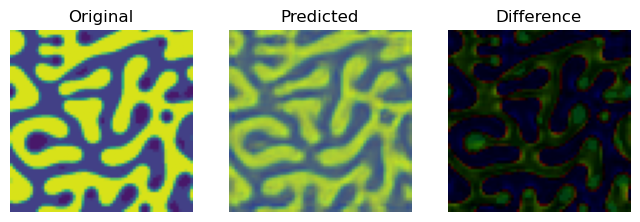

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(8,8))
axes[0].imshow(y_val[6][0])
axes[0].axis('off')
axes[0].set_title('Original')
axes[1].imshow(preds[6][0])
axes[1].axis('off')
axes[1].set_title('Predicted')

heatmap= preds[6][0]-y_val[6][0]
axes[2].set_title('Difference')
axes[2].axis('off')
im=axes[2].imshow(heatmap)

